In [2]:
import pandas as pd
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
img=cv2.imread("test_images/sharapova1.jpg")

In [4]:
img.shape

(555, 700, 3)

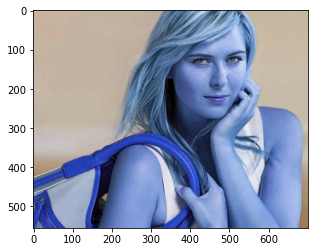

In [5]:
plt.imshow(img)

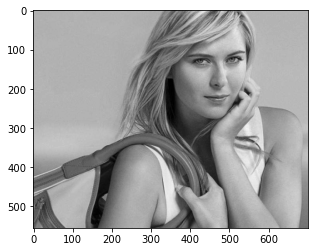

In [6]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

In [7]:
gray.shape

(555, 700)

In [8]:
gray

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], dtype=uint8)

In [9]:
face_cascade=cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade=cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_eye.xml")

faces=face_cascade.detectMultiScale(gray,1.3,5)
faces

array([[352,  38, 233, 233]])

In [10]:
(x,y,w,h)=faces[0]
x,y,w,h

(352, 38, 233, 233)

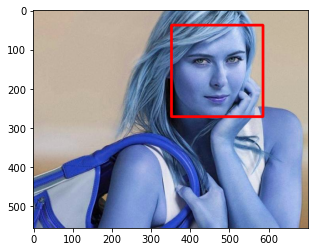

In [11]:
face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
plt.imshow(face_img)

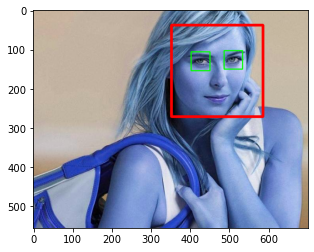

In [12]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

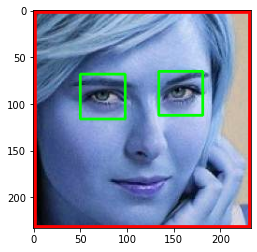

In [13]:
plt.imshow(roi_color, cmap='gray')

In [14]:
cropped_img = np.array(roi_color)
cropped_img.shape

(233, 233, 3)

(3) Preprocessing: Use wavelet transform as a feature for traning our model

In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc
Wavelet transform

In [15]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

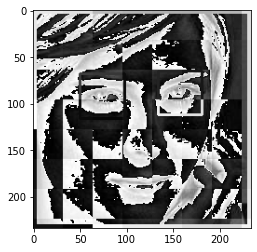

In [16]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region
Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [19]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

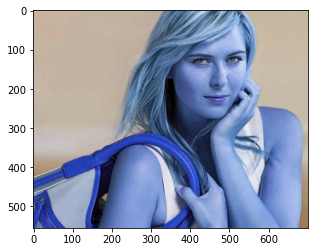

In [17]:
original_image = cv2.imread('./test_images/sharapova1.jpg')
plt.imshow(original_image)

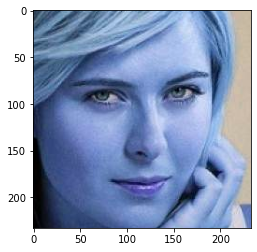

In [20]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')
plt.imshow(cropped_image)

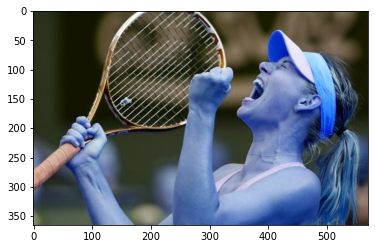

In [21]:
org_image_obstructed = cv2.imread('./test_images/sharapova2.jpg')
plt.imshow(org_image_obstructed)

Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [22]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

In [23]:
path_to_data = "./datasets/"
path_to_cr_data = "./datasets/cropped/"

In [24]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [25]:
img_dirs

['./datasets/cropped',
 './datasets/lionel_messi',
 './datasets/maria_sharapova',
 './datasets/roger_federer',
 './datasets/serena_williams',
 './datasets/virat_kohli']

In [26]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [27]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    

cropped
lionel_messi
Generating cropped images in folder:  ./datasets/cropped/lionel_messi
maria_sharapova
Generating cropped images in folder:  ./datasets/cropped/maria_sharapova
roger_federer
Generating cropped images in folder:  ./datasets/cropped/roger_federer
serena_williams
Generating cropped images in folder:  ./datasets/cropped/serena_williams
virat_kohli
Generating cropped images in folder:  ./datasets/cropped/virat_kohli


Now you should have cropped folder under datasets folder that contains cropped images
Manually examine cropped folder and delete any unwanted images

In [28]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./datasets/cropped/lionel_messi\\lionel_messi1.png',
  './datasets/cropped/lionel_messi\\lionel_messi10.png',
  './datasets/cropped/lionel_messi\\lionel_messi11.png',
  './datasets/cropped/lionel_messi\\lionel_messi13.png',
  './datasets/cropped/lionel_messi\\lionel_messi14.png',
  './datasets/cropped/lionel_messi\\lionel_messi15.png',
  './datasets/cropped/lionel_messi\\lionel_messi16.png',
  './datasets/cropped/lionel_messi\\lionel_messi17.png',
  './datasets/cropped/lionel_messi\\lionel_messi18.png',
  './datasets/cropped/lionel_messi\\lionel_messi19.png',
  './datasets/cropped/lionel_messi\\lionel_messi2.png',
  './datasets/cropped/lionel_messi\\lionel_messi20.png',
  './datasets/cropped/lionel_messi\\lionel_messi22.png',
  './datasets/cropped/lionel_messi\\lionel_messi23.png',
  './datasets/cropped/lionel_messi\\lionel_messi24.png',
  './datasets/cropped/lionel_messi\\lionel_messi25.png',
  './datasets/cropped/lionel_messi\\lionel_messi26.png',
  './datasets/cro

In [29]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [30]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [31]:
len(X[0])

4096

In [32]:
32*32*3 + 32*32

4096

In [33]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

In [34]:
y[0]

0

In [35]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(169, 4096)

Data cleaning process is done. Now we are ready to train our model

In [37]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8604651162790697

In [39]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      1.00      1.00        10
           2       0.56      1.00      0.71         5
           3       0.75      0.67      0.71         9
           4       1.00      0.92      0.96        12

    accuracy                           0.86        43
   macro avg       0.86      0.86      0.84        43
weighted avg       0.90      0.86      0.87        43



Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [40]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [41]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [42]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.785231,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.634769,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.776923,{'logisticregression__C': 5}


In [43]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [44]:
best_estimators['svm'].score(X_test,y_test)

0.8604651162790697

In [45]:
best_estimators['random_forest'].score(X_test,y_test)

0.7441860465116279

In [46]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8837209302325582

In [47]:
best_clf = best_estimators['logistic_regression']

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  0,  0,  1,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  1,  4,  0,  0],
       [ 0,  1,  2,  6,  0],
       [ 0,  0,  0,  0, 12]], dtype=int64)

Text(69.0, 0.5, 'Truth')

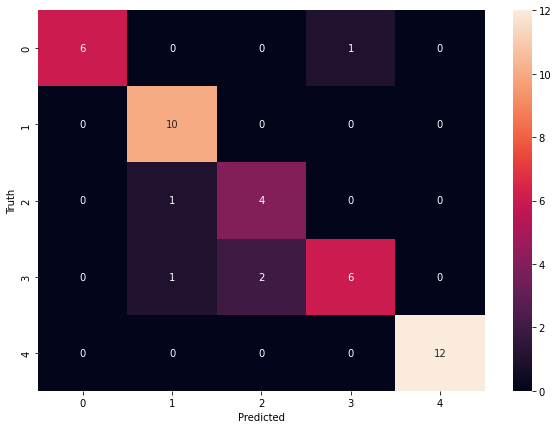

In [49]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

Save the trained model

In [52]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

Save class dictionary

In [53]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))